In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from config import *
from models import *
from datasets import *

In [22]:
config.perception = "valkyr"
#config.itrs = 1
model = SceneLearner(config)
model.scene_perception = ValkyrNet(config)
model = torch.load("checkpoints/sprites_temp.ckpt",map_location="cpu")

spnet = model.scene_perception

#spnet.spatial_coords = None
#spnet.spatial_fourier_features = None
#spnet.spatial_edges =  None

torch.save(model,"optmodel.ckpt")



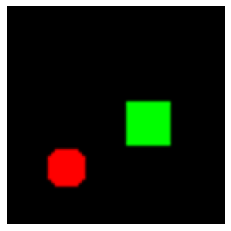

In [23]:
B = 1
shuffle = 1
#dataset = ToyDataWithQuestions(split = "train", resolution = (128,128))
dataset = SpriteWithQuestions(resolution = (128,128))
dataloader = DataLoader(dataset, batch_size = B, shuffle = shuffle)

# [Get A Sample Data]
for sample in dataloader:
    sample = sample
plt.axis("off")
plt.imshow(sample["image"][0])

In [31]:
with torch.no_grad():
    perception_outputs = model.scene_perception(sample["image"], test = True)


Convs: 0:00:00.224335
GraphConvs: 0:00:01.117623
Render: 0:00:00.025466
Recons: 0:00:00.000515


In [25]:
class Convs(nn.Module):
    def __init__(self, in_dim, out_dim, latent_dim = 128):
        super().__init__()
        self.pre = nn.Conv2d(in_dim, latent_dim,5,1,2)
        self.conv_modules = nn.ModuleList([
            nn.Conv2d(latent_dim, latent_dim,5,1,2) for _ in range(4)
        ])
        self.after = nn.Conv2d(latent_dim, out_dim,5,1,2)
    def forward(self,x):
        x = self.pre(x)
        for module in self.conv_modules:
            x = module(x)
        x = self.after(x)
        return x
cvs = Convs(3,10)

In [29]:

inputs = sample["image"].permute(0,3,1,2)
print(inputs.shape)
outputs = cvs(inputs)
print(outputs.shape)

torch.Size([1, 3, 128, 128])
torch.Size([1, 10, 128, 128])


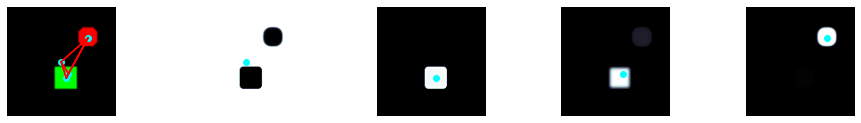

In [32]:


def calculate_masks(scores, connections):
    all_masks = []
    for i in range(len(connections)):
        curr_mask = scores[i+1].unsqueeze(-1)
        for connection in reversed(connections[:i+1]):
            curr_mask = torch.bmm(connection, curr_mask) # [BxNxM],[BxM]
        all_masks.append(curr_mask)
    return all_masks



def display_batch(sample,outputs,batch = 0,file_name = "temp.png"):
    
    B, W, H, C = sample["image"].shape

    count = 0
    for i, masks in enumerate(reversed(outputs["masks"])):
        B, N, K = masks.shape
        count += 1
        plt.figure("display_{}".format(i), figsize=(K * 4, 2))
        
        plt.subplot(1, K + 1, 1)
        plt.axis("off")
        plt.imshow(sample["image"][0].permute(1,0,2))

        layer_connection = outputs["scene_tree"]["edges"][-i-1][batch].detach()
        poses = outputs["poses"][-i-1]["centers"][batch].detach()
        #poses[:] = 1 - poses[:]
    
        for i in range(K):
            for j in range(K):
                plt.plot((W*poses[i,0],W*poses[j,0]),\
                         (H*poses[i,1],H*poses[j,1]),color = "red",\
                             alpha = 1.0 #float(layer_connection[i][j].clamp(0.0,1.0))
                    )
        plt.scatter(poses[:,0] * W, poses[:,1] * H, c = "cyan")

        for j in range(K):
            plt.subplot(1, K + 1, 2 + j)
            plt.axis("off")
            plt.imshow(masks.detach()[batch][:,j].reshape(W,H).permute(1,0), cmap="bone")
            plt.scatter(poses[j,0] * W, poses[j,1] * H, c = "cyan")
        plt.savefig("outputs/display_{}.png".format(count))

display_batch(sample,perception_outputs)
plt.show()

{'pos': (0, 0), 'height': 141}


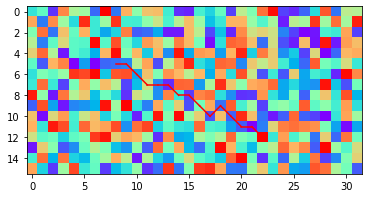

In [28]:
from Karanir.algs.graph import *
import matplotlib.pyplot as plt

gridworld = GridGraph(16,32)

def test_metric(a,b):return abs(a["height"]+b["height"])+0.1
gridworld.metric = test_metric

for node in gridworld.nodes:
    gridworld.node_attributes[node]["height"] = np.random.randint(0,400)

dists, path = gridworld.bellman_ford((5,8), to=(12,22))

def gridworld_color_map(node):
    return node["height"]
render_results = gridworld.render(path,cmap = gridworld_color_map)

plt.imshow(render_results, cmap="rainbow")
plt.show()



In [ ]:
from torchvision.models.optical_flow import raft_large, Raft_Large_Weights

# If you can, run this example on a GPU, it will be a lot faster.
device = "cuda" if torch.cuda.is_available() else "cpu"

weights = Raft_Large_Weights.DEFAULT
transforms = weights.transforms()


def preprocess(img1_batch, img2_batch, resolution = (128,128)):
    img1_batch = F.resize(img1_batch, size=resolution, antialias=False)
    img2_batch = F.resize(img2_batch, size=resolution, antialias=False)
    return transforms(img1_batch, img2_batch)


img1_batch, img2_batch = preprocess(img1_batch, img2_batch)

model = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=False).to(device)
model = model.eval()

list_of_flows = model(img1_batch.to(device), img2_batch.to(device))